In [1]:
import numpy as np 
import pandas as pd 
import pickle

# visualizatioion pkg 
import seaborn as sns 
import matplotlib.pyplot as plt 
%matplotlib inline
%config InlineBackend.figure_format='retina'

import sys
sys.path.append('..')

from utils.viz import viz 
from utils.model import *  
from utils.fig_fn import *
viz.get_style()

In [2]:
exp = 'exp2'
block_types = ['cons', 'cont', 'conf']
agents = ['LC', 'ACL', 'ecPG_fea']
method = 'mle'
dpi = 300

### Fig. 6A model comparison

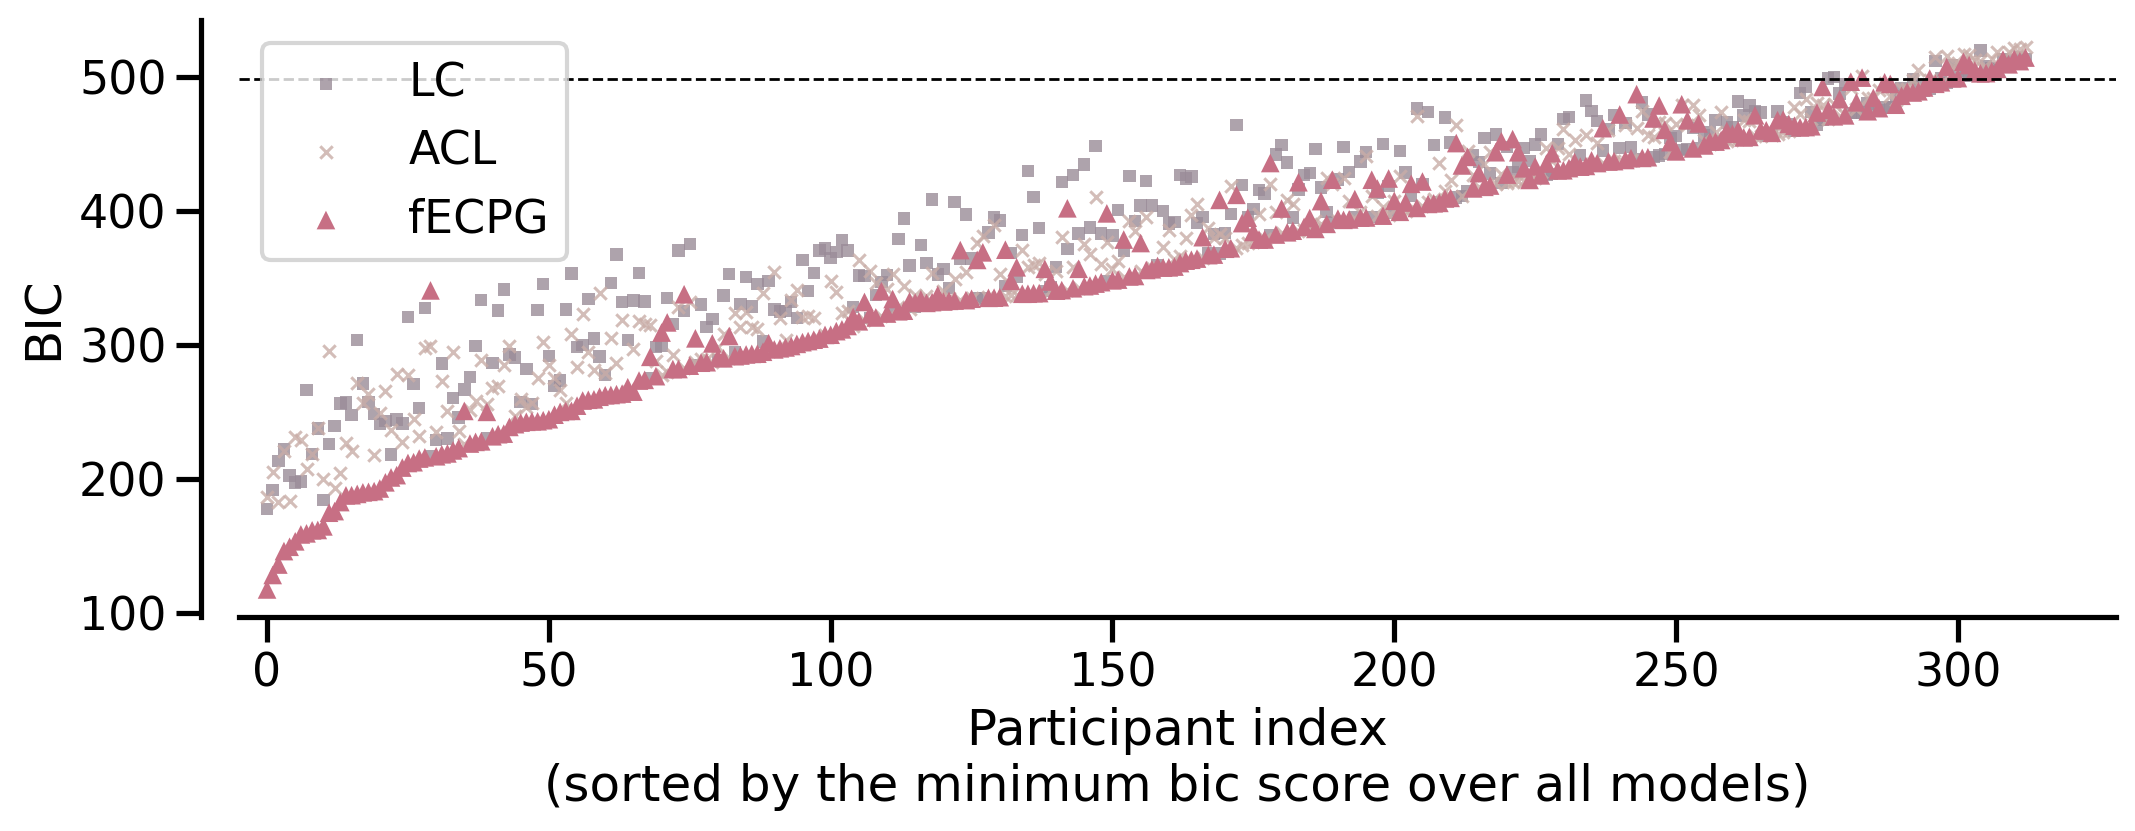

In [3]:
crs_table = get_crs(exp=exp, agents=agents)
viz_model_cmp(crs_table, exp=exp, agents=agents, crs='bic')
plt.savefig('../figures/exp2/fIg7A_modelcomp.pdf', dpi=dpi)

[0. 0. 1.]


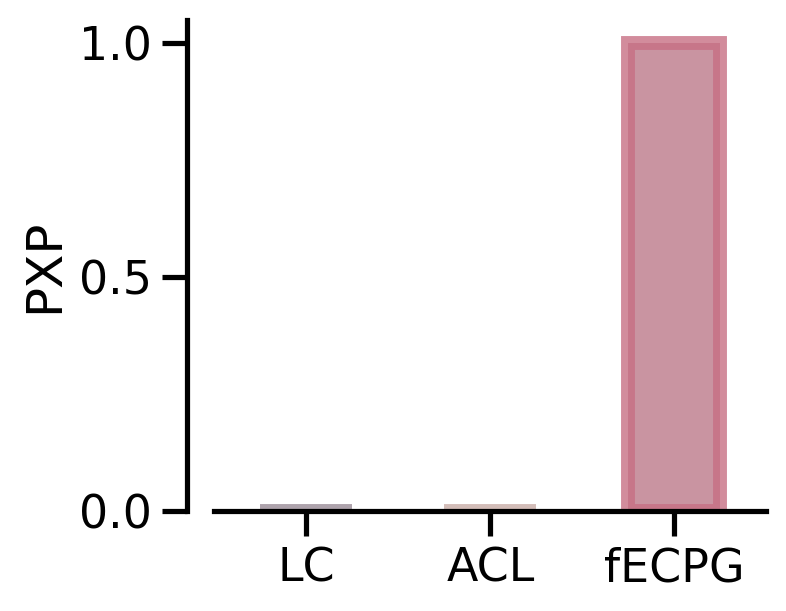

In [4]:
viz_pxp(exp, agents, method)
plt.savefig('../figures/exp2/fIg7A_pxp.pdf', dpi=dpi)

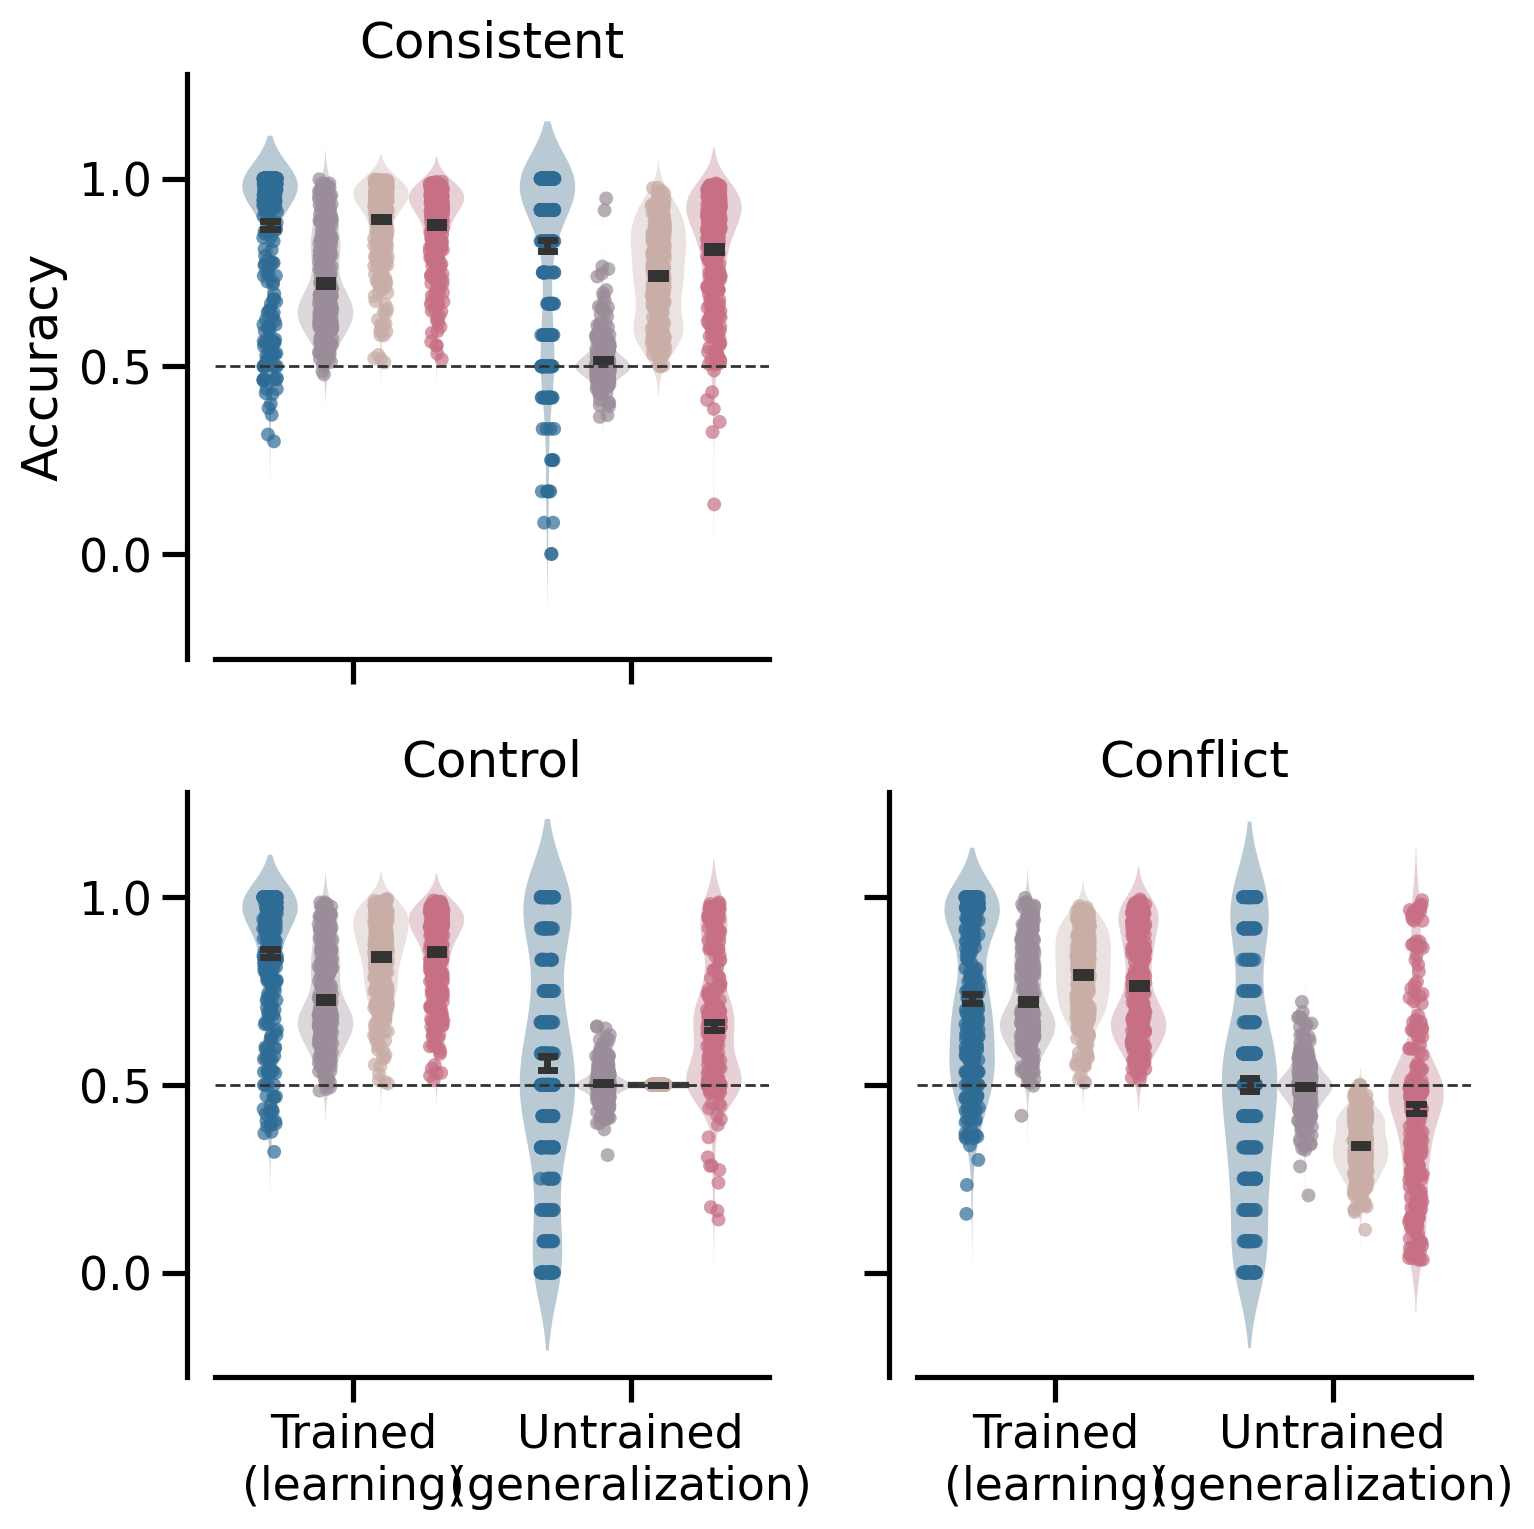

In [5]:
viz_transfer_cond(exp, ['human']+agents, method)
plt.savefig('../figures/exp2/fIg7B_functional.pdf', dpi=dpi)

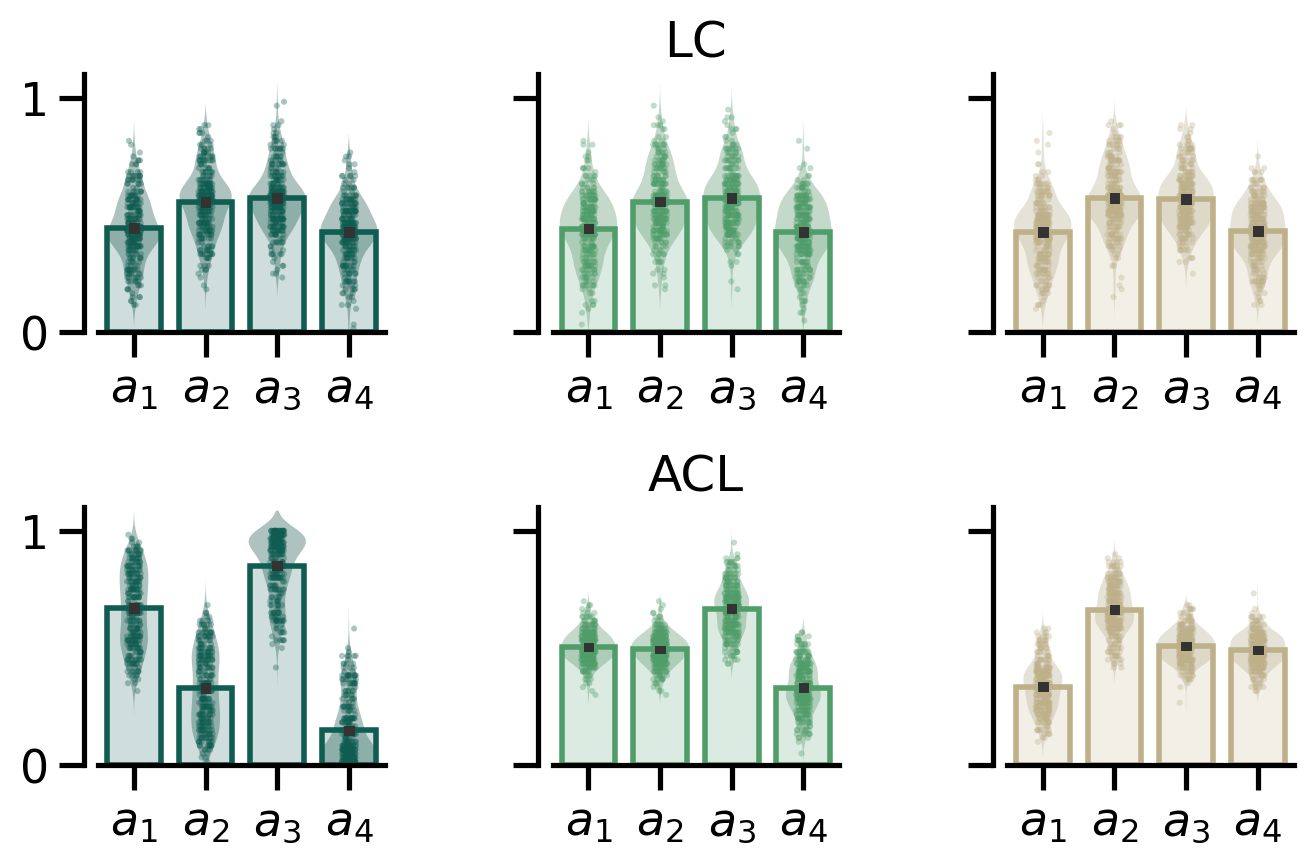

In [6]:
viz_Probe(exp, ['LC', 'ACL'], method)
plt.savefig('../figures/exp2/fIg7C_perceptual.pdf', dpi=dpi)

In [7]:
def corr_matrix(exp, agents = ['rmPG_fea', 'caPG_fea', 'ecPG_fea'], method='mle', goodPoor=None):
    p_tables = {}
    conds = ['cons', 'cont', 'conf']
    for i, agent in enumerate(['human']+agents):
        if agent == 'human':
            fname = f'{pth}/../data/{exp}-human.csv'
            s = 1
        else:
            fname = f'{pth}/../simulations/{exp}/{agent}/sim-{method}.csv'
            s = 10
        data = pd.read_csv(fname, index_col=0)
        sel_data = data.query('group=="probe"').reset_index()
        pp = {}
        for j, cond in enumerate(['cons', 'cont', 'conf']):
            sdata = sel_data.query(f'block_type=="{cond}"')
            if goodPoor is not None: sdata = sdata.query(f'goodPoor=="good"') 
            gdata = sdata.groupby(by=['sub_id', 'a', 'block_type']).count()['r'].reset_index()
            ptable = gdata.pivot_table(values='r', index='sub_id', columns='a').fillna(0) / (6*s)
            ptable.columns = [0, 1, 2, 3]
            ptable = ptable.reset_index()
            pp[cond] = ptable.sort_values(by='sub_id').loc[:, [0, 1, 2, 3]].values
        p_tables[agent] = pp
    corr_data = {'corr': [], 'agent':[], 'cond':[]}
    for i, cond in enumerate(conds):
        y = p_tables['human'][cond][:, 0::2].reshape([-1])
        for agent in agents:
            x = p_tables[agent][cond][:, 0::2].reshape([-1])
            corr_lm = pg.corr(x, y, method='spearman')
            print(corr_lm)
            r = corr_lm["r"][0]
            corr_data['corr'].append(r)
            corr_data['agent'].append(agent)
            corr_data['cond'].append(cond)
    corr_data = pd.DataFrame.from_dict(corr_data).pivot_table(
                    values='corr', index='cond', columns='agent'
                    ).loc[['cons', 'cont', 'conf'], agents]
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    sns.heatmap(corr_data, cmap="coolwarm",  center=.3, vmax=1.2,
                square=True, annot=True, cbar_kws={"shrink": .5},
                lw=1, ax=ax)
    ax.set_xticklabels([eval(agent).name for agent in agents])
    ax.set_yticklabels(['Consistent', 'Control', 'Conflict'])
    ax.set_xlabel('')
    ax.set_ylabel('')


            n         r          CI95%     p-val     power
spearman  626  0.071524  [-0.01, 0.15]  0.073739  0.432406
            n         r         CI95%         p-val  power
spearman  626  0.594588  [0.54, 0.64]  4.156629e-61    1.0
            n         r         CI95%     p-val     power
spearman  626  0.087034  [0.01, 0.16]  0.029453  0.586859
            n         r        CI95%     p-val     power
spearman  626  0.181421  [0.1, 0.26]  0.000005  0.995634
            n         r          CI95%     p-val     power
spearman  626  0.050714  [-0.03, 0.13]  0.205101  0.245012
            n         r         CI95%     p-val     power
spearman  626  0.112558  [0.03, 0.19]  0.004809  0.806059


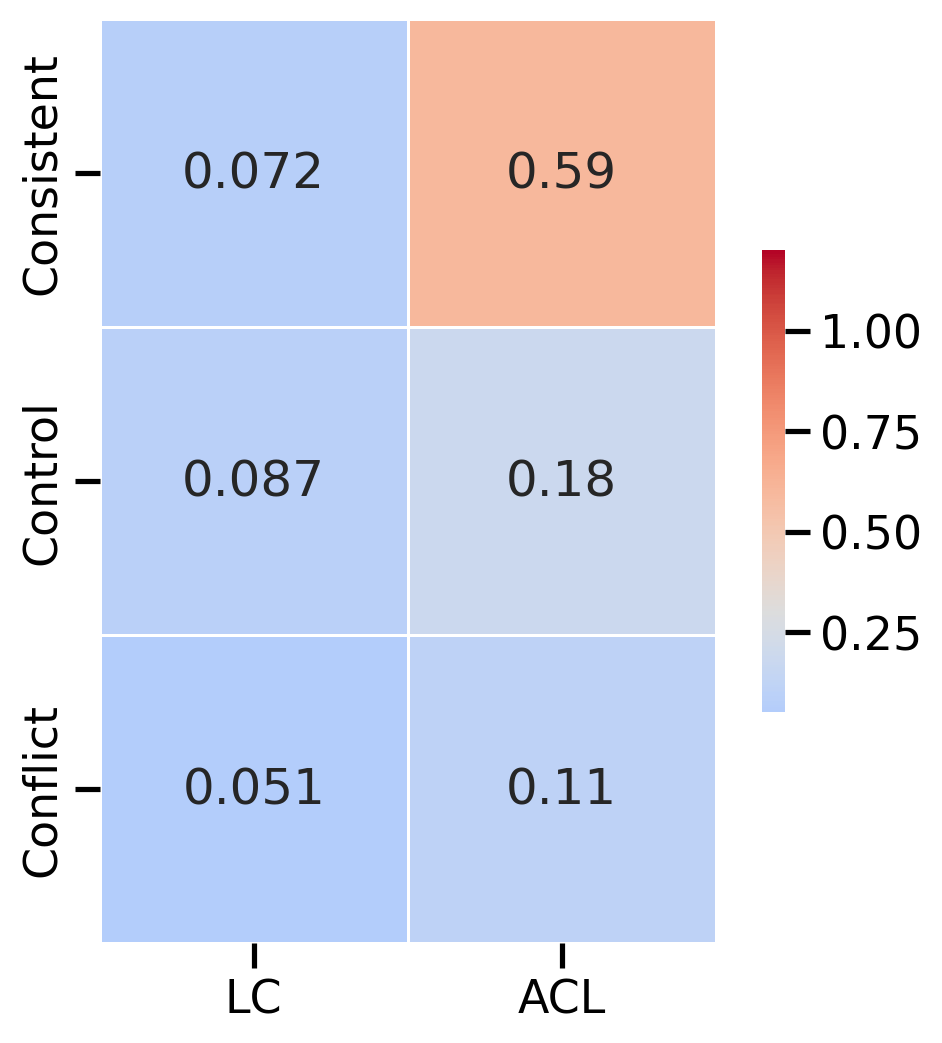

In [8]:
corr_matrix(exp, agents=['LC', 'ACL'])
plt.savefig('../figures/exp2/fIg7D_corrMat.pdf', dpi=dpi)

In [8]:
def simulate(data, args, seed):

    # define the subj
    model = wrapper(args.agent, env_fn=AEtask)

    ## Loop to choose the best model for simulation
    # the last column is the loss, so we ignore that
    sim_data = []
    sub_idx = list(data.keys())[0]
    # 'η', 'α', 'β', 'w0', 'p'
    eta   = .24
    alpha = .01
    beta  = 5
    w0    = .1
    p     = .1
    tau   = 1
    params = [np.log(eta)-np.log(1-eta), np.log(alpha), 
              np.log(beta), w0, np.log(p)]
   
    # synthesize the data and save
    rng = np.random.RandomState(seed)
    sim_sample = model.sim(data[sub_idx], params, rng=rng)
    sim_data.append(sim_sample)
    seed += 1

    return pd.concat(sim_data, axis=0, ignore_index=True)

'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp


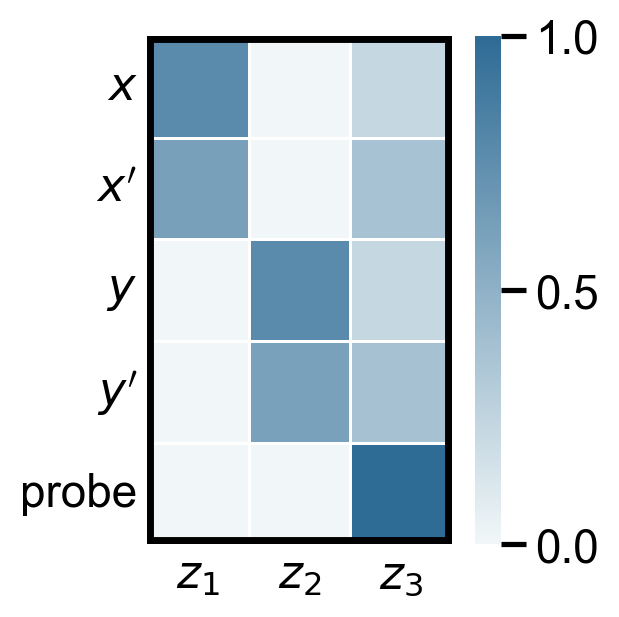

In [18]:
p_Z1F = np.array([[[0.66, 0.33, 0.  , 0.  , 0.  ],
                [0.66, 0.33, 0.  , 0.  , 0.  ],
                [0.66, 0.33, 0.  , 0.  , 0.  ]],

                [[0.  , 0.  , 0.68, 0.31, 0.  ],
                [0.  , 0.  , 0.68, 0.31, 0.  ],
                [0.  , 0.  , 0.68, 0.31, 0.  ]],

                [[0.2 , 0.2 , 0.2 , 0.2 , 0.2 ],
                [0.2 , 0.2 , 0.2 , 0.2 , 0.2 ],
                [0.2 , 0.2 , 0.2 , 0.2 , 0.2 ]]]).reshape([3, -1])
F = np.vstack([np.tile(np.eye(5)[s], [1, 3]) for s in range(5)])
p_Z1S = ((F@p_Z1F.T) / (F@p_Z1F.T).sum(1, keepdims=True)).round(2)

fig, axs = plt.subplots(1, 1, figsize=(3, 3.3))
ax = axs
sns.heatmap(p_Z1S, square=True, lw=.5, 
            cmap=viz.BluesMap, vmin=0, vmax=1, 
            cbar_kws={"ticks":[0, .5, 1]}, 
            ax=ax)
yt = [r"$x $ ", r"$x'$", r"$y $ ", r"$y'$", 'probe']
xt = [r"$z_1$", r"$z_2$", r"$z_3$"]
ax.axhline(y=0, color='k',lw=5)
ax.axhline(y=p_Z1S.shape[0], color='k',lw=5)
ax.axvline(x=0, color='k',lw=5)
ax.axvline(x=p_Z1S.shape[1], color='k',lw=5)
ax.set_xticks([.5, 1.5, 2.5])
ax.set_xticklabels(xt)
ax.xaxis.set_tick_params(length=0)
ax.set_yticks([.5, 1.5, 2.5, 3.5, 4.5])
ax.set_yticklabels(yt, rotation=0)
ax.yaxis.set_tick_params(length=0)
plt.savefig('../figures/exp2/fIg7E_LClatent.pdf', dpi=dpi)


In [13]:
def sim_Attn(exp, agent_name, block_types):
    lws = [6.5, 6.5, 3.5]
    voi ={}
    for block_type in block_types:
        
        fname = f'{pth}/../simulations/{exp}/{agent_name}/simsubj-{block_type}_voi'
        fname += f'-η=0.65-β=10-ε=0.04-η_a=0.6.pkl'
        with open(fname, 'rb')as handle: voi[block_type] = pickle.load(handle)

    block_names = ['Consistent', 'Control', 'Conflict']
    features = ['Shape', 'Color', 'Appendage']
    tars = ['trial', 'attn', 'block_type', 'feature']
    df = {tar: [] for tar in tars}
    features = ['Shape', 'Color', 'Appendage']
    for i, b in enumerate(block_types):
        attn  = np.vstack(voi[b]['attn'])
        T = len(voi[b]['attn'])
        for j, f in enumerate(features):
            df['trial'] += list(range(T))
            df['attn'] += list(attn[:, j])
            df['block_type'] += [b]*T
            df['feature'] += [f]*T
    data = pd.DataFrame.from_dict(df)

    fig, axs = plt.subplots(1, 3, figsize=(5*3, 2.5), sharex=True)
    for k, b in enumerate(block_types):
        ax = axs[k]
        for i, f in enumerate(features):
            sns.lineplot(x='trial', y='attn', lw=lws[i],
                        data=data.query(f'block_type=="{b}" & feature=="{f}"'),
                        color=viz.Pal_fea[i], ax=ax, label=f)
            #ax.hlines(y=0, xmin=0, xmax=60, lw=1, ls='--', color='k')
        ax.legend().remove()
        ax.set_title(f'{block_names[k]}')
        #ax.set_ylim([.0, 5])
        ax.set_ylabel('Attention (a.u.)') 
        ax.set_box_aspect(.45)
        ax.yaxis.set_tick_params(labelleft=True)
        ax.spines['left'].set_position(('axes',-0.05))
    
    fig.tight_layout()

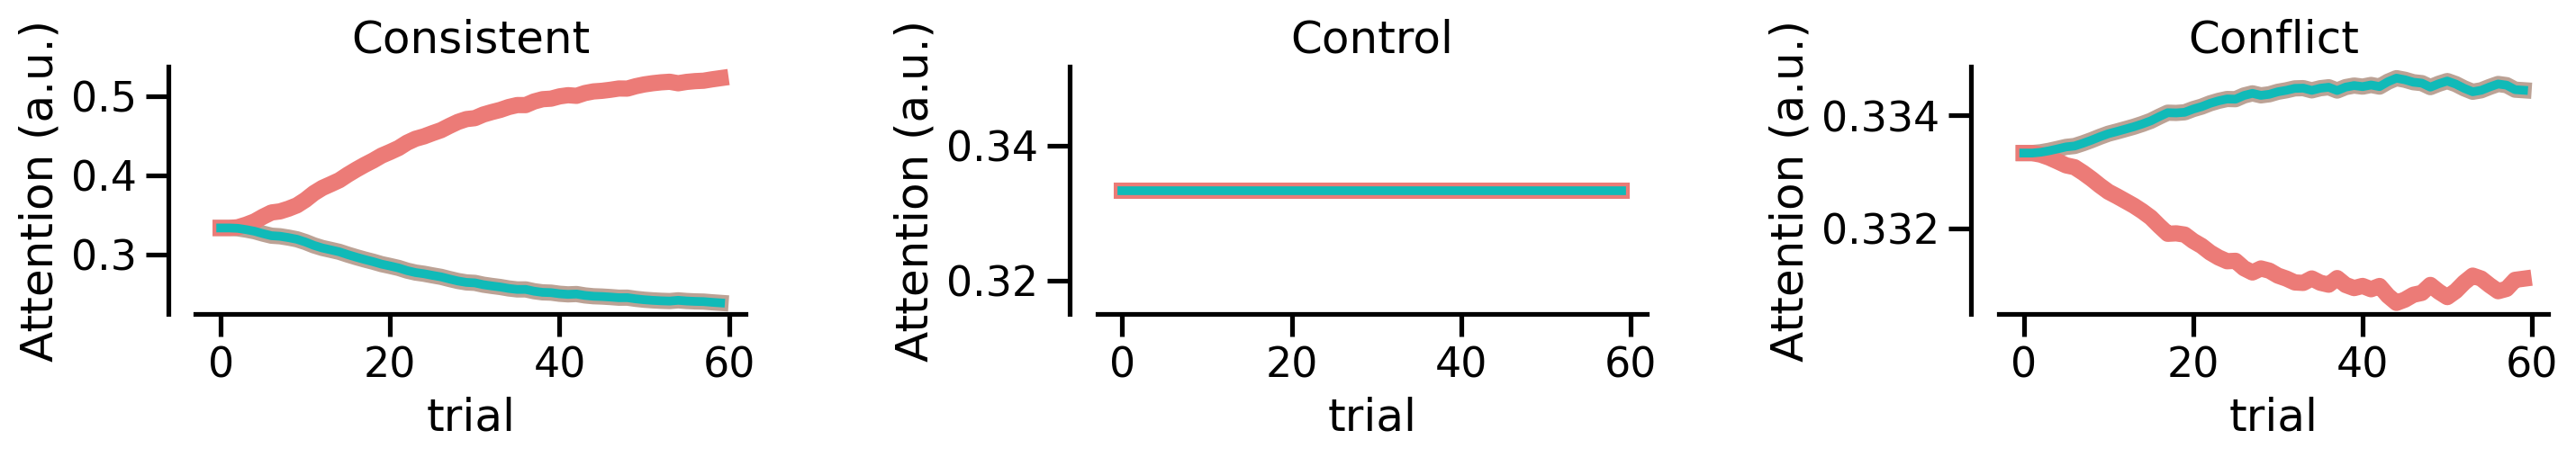

In [14]:
sim_Attn(exp, 'ACL', block_types=['cons', 'cont', 'conf'])
plt.savefig('../figures/exp2/fIg7F_attn_ACL.pdf', dpi=dpi)